姓名：赵永权<br>
学号：2016011715<br>
学院：软件学院<br>
专业：软件工程<br>

实训作业一：Clustering Schoolwork

In [1]:
# 导入必要的工具包
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
%matplotlib inline 
# 计算data(ndarray形式)的权重（邻接）矩阵
def adj_mat(data):
    n = data.shape[0]
    dist_mat = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            dist_mat[i,j] = np.dot(data[i]-data[j],data[i]-data[j])
            if(i!=j):
                dist_mat[j,i] = dist_mat[i,j]         
    adj_mat = np.exp(-0.5*dist_mat)
    return adj_mat
# 根据邻接矩阵计算每个样本的q近邻
def q_neighbors(A,q=16):
    n = []
    for i in range(len(A)):
        inds = np.argsort(A[i])
        inds = inds[-q:-1]
        n.append(inds)
    return np.array(n)

In [3]:
# 导入iris数据集及其布局文件
layout = pd.read_csv("./iris_layout.txt",sep=" ",header=None)
iris = pd.read_csv("./iris_data.txt",header=None)
# 将iris数据集的标签列进行编码，并将数据与标签分开
label_mapping={'Iris-versicolor':2,'Iris-setosa':1,'Iris-virginica':0}
label = np.array(iris[4].map(label_mapping))
data = np.array(iris[[1,2,3]])

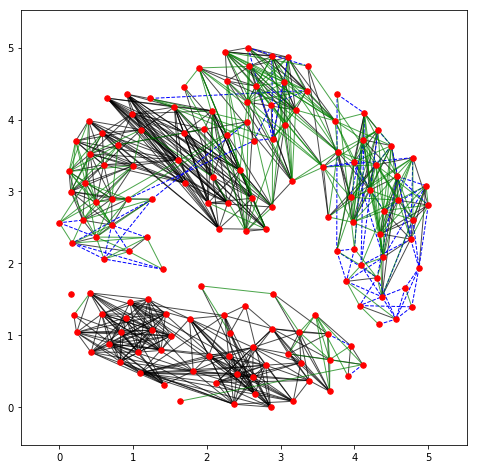

In [26]:
# 将鸢尾花数据集画成图的形式(聚类之前)
A = adj_mat(data)
pos = np.array(layout)
qnn = q_neighbors(A)
        
plt.figure(figsize=(8,8))
G = nx.Graph()  
# 向图G添加节点和边
G.add_nodes_from([i for i in range(150)])
for i in range(len(A)):
    for j in range(len(A)):
        # 只有i是j的近邻且j是i的近邻，二者之间才有边
        if(i in qnn[j] and j in qnn[i]):
            G.add_edge(i,j,weight=A[i,j])
# 画出节点           
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=30, node_shape='o')
# 将图G中的边按照权重分组
edges_list1=[]
edges_list2=[]
edges_list3=[]
for (u,v,d) in G.edges(data='weight'):
    if d > 0.95:
        edges_list1.append((u,v))
    elif d < 0.9:
        edges_list2.append((u,v))
    else:
        edges_list3.append((u,v))
# 按照分好的组，以不同样式画出边
nx.draw_networkx_edges(G, pos, edgelist=edges_list1, width=1, alpha=0.7, edge_color='k', style='solid')
nx.draw_networkx_edges(G, pos, edgelist=edges_list2, width=1, alpha=1.0, edge_color='b', style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=edges_list3, width=1, alpha=0.7, edge_color='g', style='solid')
plt.savefig("iris_graph.png")
plt.show()

In [27]:
# 对X进行谱聚类，取前K个（从小到大）单位化的特征向量
def spectral_clustering(X,k):
    A = adj_mat(X)
    D = np.diag(A.sum(axis=0))
    L = D - A  # Laplace Matrix
    D = np.linalg.inv(np.sqrt(D))
    L = D.dot(L).dot(D)
    w, v = np.linalg.eig(L)
    inds = np.argsort(w)[:k]
    Vectors = v[:, inds]
    normalizer = np.linalg.norm(Vectors, axis=1)  # normalized
    normalizer = np.repeat(np.transpose([normalizer]), k, axis=1)
    Vectors = Vectors / normalizer
    return Vectors

In [28]:
# 对谱聚类得出的数据进行K-means聚类
# 初始化质心
def init_centroids(data,k):
    centroids_idx = np.random.choice(data.shape[0], size=k)
    centroids = [data[i] for i in centroids_idx]
    return np.array(centroids)
# 根据质心划分簇
def split_cluster(data, centroids):
    clusters = [[] for i in range(centroids.shape[0])]
    for i in range(data.shape[0]):
        dist = np.square(data[i]-centroids).sum(axis=1)
        idx = np.argmin(dist)
        clusters[idx].append(i)
    return np.array(clusters)
# 更新质心
def update_centroids(clusters, data):
    n_features = data.shape[1]
    k = clusters.shape[0]
    centroids = np.zeros((k,n_features))
    for i, cluster in enumerate(clusters):
        centroid = np.mean(data[cluster],axis=0)
        centroids[i] = centroid
    return centroids
# 得到聚簇后的类别标签
def get_cluster_labels(clusters, data):
    y_pred = np.zeros(data.shape[0], dtype=np.int32)
    for cluster_i, cluster in enumerate(clusters):
        for sample_i in cluster:
            y_pred[sample_i] = cluster_i
    return y_pred
# 对整个数据集data进行Kmeans聚类，返回其聚类的标签
def k_means(data,k,max_iter,epsilon):
    # 从所有样本中随机选取k个样本作为初始的聚类中心
    centroids = init_centroids(data,k)  
    # 迭代，直到算法收敛(上一次的聚类中心和这一次的聚类中心几乎重合)或者达到最大迭代次数
    for _ in range(max_iter):
        # 将所有数据进行归类，归类规则就是将该样本归类到与其最近的中心
        clusters = split_cluster(data,centroids)
        former_centroids = centroids
        # 计算新的聚类中心
        centroids = update_centroids(clusters, data)
        # 如果聚类中心几乎没有变化，说明算法已经收敛，退出迭代
        diff = centroids - former_centroids
        if diff.any() < epsilon:
            break
    return get_cluster_labels(clusters, data)

In [29]:
label

array([2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 0,
       1, 2, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0,
       2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2,
       0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       1, 0, 1, 1, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 1, 0, 1, 1,
       2, 1, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 2, 1, 1, 2, 1, 2, 0, 1, 0,
       0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 0, 1], dtype=int64)

In [39]:
sp_data = spectral_clustering(data,3)
pred = k_means(sp_data,3,2000,0.001)
pred

array([2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 0,
       1, 2, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0,
       2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2,
       0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 2, 1, 2, 0, 2, 2, 0, 0, 2, 2, 0,
       1, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 1, 0, 1, 1,
       2, 1, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0,
       0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 1])

In [41]:
# 计算分簇正确率
cnt = 0
for i in range(150):
    if label[i] == pred[i]:
        cnt += 1
acc = cnt / 150
acc

0.9533333333333334

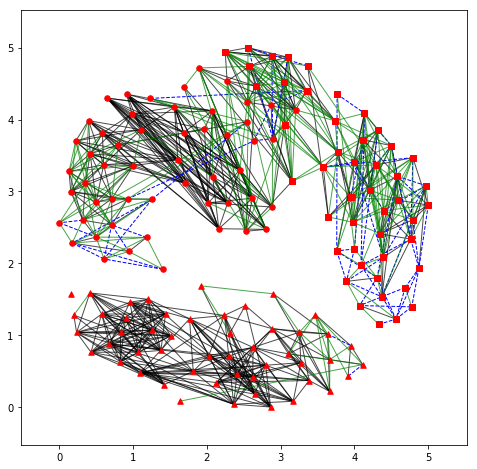

In [42]:
# 谱聚类之后再次可视化成图的形式
plt.figure(figsize=(8,8))
N = nx.Graph()
# 给图N添加顶点和边
N.add_nodes_from([i for i in range(150)])
A = adj_mat(data)
qnn = q_neighbors(A)
for i in range(len(A)):
    for j in range(len(A)):
        if(i in qnn[j] and j in qnn[i]):
            N.add_edge(i,j, weight=A[i,j])
#按簇标签将节点分组         
nodes_list1=[i for i in range(150) if pred[i] == 2]
nodes_list2=[i for i in range(150) if pred[i] == 1]
nodes_list3=[i for i in range(150) if pred[i] == 0]
# 按照权重将边分组
edges_list1=[]
edges_list2=[]
edges_list3=[]
for (u,v,d) in G.edges(data='weight'):
    if d > 0.95:
        edges_list1.append((u,v))
    elif d < 0.9:
        edges_list2.append((u,v))
    else:
        edges_list3.append((u,v))
# 画出节点
nx.draw_networkx_nodes(N, pos, node_size=30, nodelist=nodes_list1, node_shape='o')
nx.draw_networkx_nodes(N, pos, node_size=30, nodelist=nodes_list2, node_shape='^')
nx.draw_networkx_nodes(N, pos, node_size=30, nodelist=nodes_list3, node_shape='s')
# 画出边
nx.draw_networkx_edges(G, pos, edgelist=edges_list1, width=1, alpha=0.7, edge_color='k', style='solid')
nx.draw_networkx_edges(G, pos, edgelist=edges_list2, width=1, alpha=1.0, edge_color='b', style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=edges_list3, width=1, alpha=0.7, edge_color='g', style='solid')
plt.savefig("sp_iris_graph.png")
plt.show()